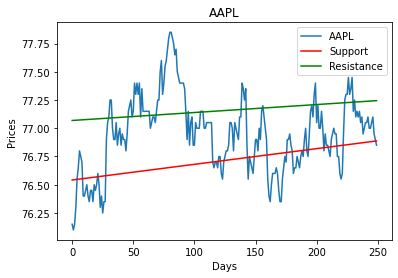

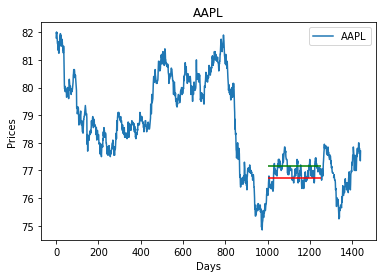

In [38]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import pandas_datareader as web
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

def pythag(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)

def regression_ceof(pts):
    X = np.array([pt[0] for pt in pts]).reshape(-1, 1)
    y = np.array([pt[1] for pt in pts])
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0], model.intercept_

def local_min_max(pts):
    local_min = []
    local_max = []
    prev_pts = [(0, pts[0]), (1, pts[1])]
    for i in range(1, len(pts) - 1):
        append_to = ''
        if pts[i-1] > pts[i] < pts[i+1]:
            append_to = 'min'
        elif pts[i-1] < pts[i] > pts[i+1]:
            append_to = 'max'
        if append_to:
            if local_min or local_max:
                prev_distance = pythag(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythag(prev_pts[1], (i, pts[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, pts[i])
                    if append_to == 'min':
                        local_min.append((i, pts[i]))
                    else:
                        local_max.append((i, pts[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, pts[i])
                if append_to == 'min':
                    local_min.append((i, pts[i]))
                else:
                    local_max.append((i, pts[i]))
    return local_min, local_max

df_raw = pd.read_csv('AAVEUSDT2022-07-10.csv')
df_raw = df_raw.drop(['tickDirection', 'trdMatchID'], axis=1)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='s')

df_all = df_raw.groupby([pd.Grouper(
    key='timestamp', freq='min')]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)

df = df_all[1000:1250]

series_all = df_all['Close']
series_all.index = np.arange(series_all.shape[0])

symbol = 'AAPL'
#df = web.DataReader(symbol, 'yahoo', '2022-01-01', '2022-04-01')
series = df['Close']
series.index = np.arange(series.shape[0])

month_diff = series.shape[0] // 30
if month_diff == 0:
    month_diff = 1

smooth = int(2 * month_diff + 3)

pts = savgol_filter(series, smooth, 3)

local_min, local_max = local_min_max(pts)

local_min_slope, local_min_int = regression_ceof(local_min)
local_max_slope, local_max_int = regression_ceof(local_max)
support = (local_min_slope * np.array(series.index)) + local_min_int
resistance = (local_max_slope * np.array(series.index)) + local_max_int

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(series, label=symbol)
plt.plot(support, label='Support', c='r')
plt.plot(resistance, label='Resistance', c='g')
plt.legend()
plt.show()

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(series_all, label=symbol)
plt.hlines(support.mean(), 1000, 1250, color = 'r')
plt.hlines(resistance.mean(), 1000, 1250, color = 'g')
plt.legend()
plt.show()